In [1]:
#hide
#default_exp vis.ei

# Visualisations Using Electric Insights Data

<br>

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd

import requests
import seaborn as sns
import matplotlib.pyplot as plt

from moepy import lowess, moe, eda, surface

<br>

### Loading EI Dataset

In [4]:
#exports
def get_ei_raw_urls(
    url: str='https://api.github.com/repos/AyrtonB/Electric-Insights/git/trees/master?recursive=1',
    raw_file_prefix: str='https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/'
):
    r_json = requests.get(url).json()

    ei_raw_urls = [
        raw_file_prefix+file['path'] 
        for file in r_json["tree"] 
        if (('data/' in file['path']) and 
            ('.csv' in file['path']))
    ]

    return ei_raw_urls

In [5]:
ei_raw_urls = get_ei_raw_urls()

ei_raw_urls

['https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2009.csv',
 'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2010.csv',
 'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2011.csv',
 'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2012.csv',
 'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2013.csv',
 'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2014.csv',
 'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2015.csv',
 'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2016.csv',
 'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2017.csv',
 'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data

In [6]:
#exports
def get_ei_df(
    dt_col: str='local_datetime',
    dt_tz: str='Europe/London',
    url: str='https://api.github.com/repos/AyrtonB/Electric-Insights/git/trees/master?recursive=1',
    raw_file_prefix: str='https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/'
):
    ei_raw_urls = get_ei_raw_urls(url, raw_file_prefix)
    df_ei = pd.concat([pd.read_csv(ei_raw_url) for ei_raw_url in ei_raw_urls])

    df_ei[dt_col] = pd.to_datetime(df_ei[dt_col], utc=True)
    df_ei = df_ei.set_index(dt_col)
    df_ei.index = df_ei.index.tz_convert(dt_tz)

    return df_ei

try:
    df_ei = get_ei_df()
except:
    df_ei = None

In [7]:
df_ei.head()

,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1.0,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2.0,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3.0,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4.0,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5.0,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


<br>

### GB Decarbonisation Progress Visualisations

#### Stacked Fuel Generation Time-Series

We'll create a stacked plot of the different generation types over time. We'll begin by cleaning the dataframe and merging columns so that it's ready for plotting, we'll also take the 7-day rolling average to make long-term trends clearer.

In [8]:
#exports
def clean_EI_df_for_plot(df, freq='7D'):
    """Cleans the electric insights dataframe for plotting"""
    fuel_order = ['Imports & Storage', 'nuclear', 'biomass', 'gas', 'coal', 'hydro', 'wind', 'solar']
    interconnectors = ['french', 'irish', 'dutch', 'belgian', 'ireland', 'northern_ireland']

    df = (df
          .copy()
          .assign(imports_storage=df[interconnectors+['pumped_storage']].sum(axis=1))
          .rename(columns={'imports_storage':'Imports & Storage'})
          .drop(columns=interconnectors+['demand', 'pumped_storage'])
          [fuel_order]
         )

    df_resampled = df.astype('float').resample(freq).mean()
    
    return df_resampled

In [9]:
df_ei_plot = clean_EI_df_for_plot(df_ei)

df_ei_plot.head()

,Imports & Storage,nuclear,biomass,gas,coal,hydro,wind,solar
local_datetime,,,,,,,,
2009-01-01 00:00:00+00:00,-0.039018,5.768536,0.0,16.295098,20.132420,0.355890,0.390015,0.0
2009-01-08 00:00:00+00:00,-0.921768,5.582896,0.0,16.381083,21.699726,0.551753,1.151545,0.0
2009-01-15 00:00:00+00:00,-0.024241,5.559986,0.0,14.839983,20.446309,0.704382,1.483002,0.0
2009-01-22 00:00:00+00:00,0.182830,6.228411,0.0,14.467771,20.590661,0.562277,0.938827,0.0
2009-01-29 00:00:00+00:00,0.079113,6.523347,0.0,13.931875,21.249219,0.533043,1.459468,0.0


<br>

We'll also define the colours we'll use for each fuel-type, we'll then convert them from rgb to matplotlib plotting colours (0-1 not 0-255).

N.b. the colour palette used is from [this paper](https://www.sciencedirect.com/science/article/pii/S0301421516307017)

In [10]:
#exports
def rgb_2_plt_tuple(r, g, b):
    """converts a standard rgb set from a 0-255 range to 0-1"""
    
    plt_tuple = tuple([x/255 for x in (r, g, b)])
    
    return plt_tuple


def convert_fuel_colour_dict_to_plt_tuple(fuel_colour_dict_rgb):
    """Converts a dictionary of fuel colours to matplotlib colour values"""
    
    fuel_colour_dict_plt = fuel_colour_dict_rgb.copy()
    
    fuel_colour_dict_plt = {
        fuel: rgb_2_plt_tuple(*rgb_tuple) 
        for fuel, rgb_tuple 
        in fuel_colour_dict_plt.items()
    }
    
    return fuel_colour_dict_plt

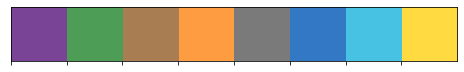

In [11]:
fuel_colour_dict_rgb = {
    'Imports & Storage' : (121,68,149), 
    'nuclear' : (77,157,87), 
    'biomass' : (168,125,81), 
    'gas' : (254,156,66), 
    'coal' : (122,122,122), 
    'hydro' : (50,120,196), 
    'wind' : (72,194,227), 
    'solar' : (255,219,65),
}

fuel_colour_dict_plt = convert_fuel_colour_dict_to_plt_tuple(fuel_colour_dict_rgb)

sns.palplot(fuel_colour_dict_plt.values())

<br>

Finally we can plot the stacked fuel plot itself

In [12]:
#exports
def hide_spines(ax, positions=["top", "right"]):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    Parameters:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), "Position must be passed as a list "

    for position in positions:
        ax.spines[position].set_visible(False)
        
def stacked_fuel_plot(
    df, 
    ax=None, 
    save_path=None, 
    dpi=150,
    fuel_colour_dict = {
    'Imports & Storage' : rgb_2_plt_tuple(121,68,149), 
    'nuclear' : rgb_2_plt_tuple(77,157,87), 
    'biomass' : rgb_2_plt_tuple(168,125,81), 
    'gas' : rgb_2_plt_tuple(254,156,66), 
    'coal' : rgb_2_plt_tuple(122,122,122), 
    'hydro' : rgb_2_plt_tuple(50,120,196), 
    'wind' : rgb_2_plt_tuple(72,194,227), 
    'solar' : rgb_2_plt_tuple(255,219,65),
}
):
    """Plots the electric insights fuel data as a stacked area graph"""
    df = df[fuel_colour_dict.keys()]
    
    if ax == None:
        fig = plt.figure(figsize=(10, 5), dpi=dpi)
        ax = plt.subplot()
    
    ax.stackplot(df.index.values, df.values.T, labels=df.columns.str.capitalize(), linewidth=0.25, edgecolor='white', colors=list(fuel_colour_dict.values()))

    plt.rcParams['axes.ymargin'] = 0
    ax.spines['bottom'].set_position('zero')
    hide_spines(ax)

    ax.set_xlim(df.index.min(), df.index.max())
    ax.legend(ncol=4, bbox_to_anchor=(0.85, 1.15), frameon=False)
    ax.set_ylabel('Generation (GW)')

    if save_path is not None:
        fig.savefig(save_path)
        
    return ax

<AxesSubplot:ylabel='Generation (GW)'>

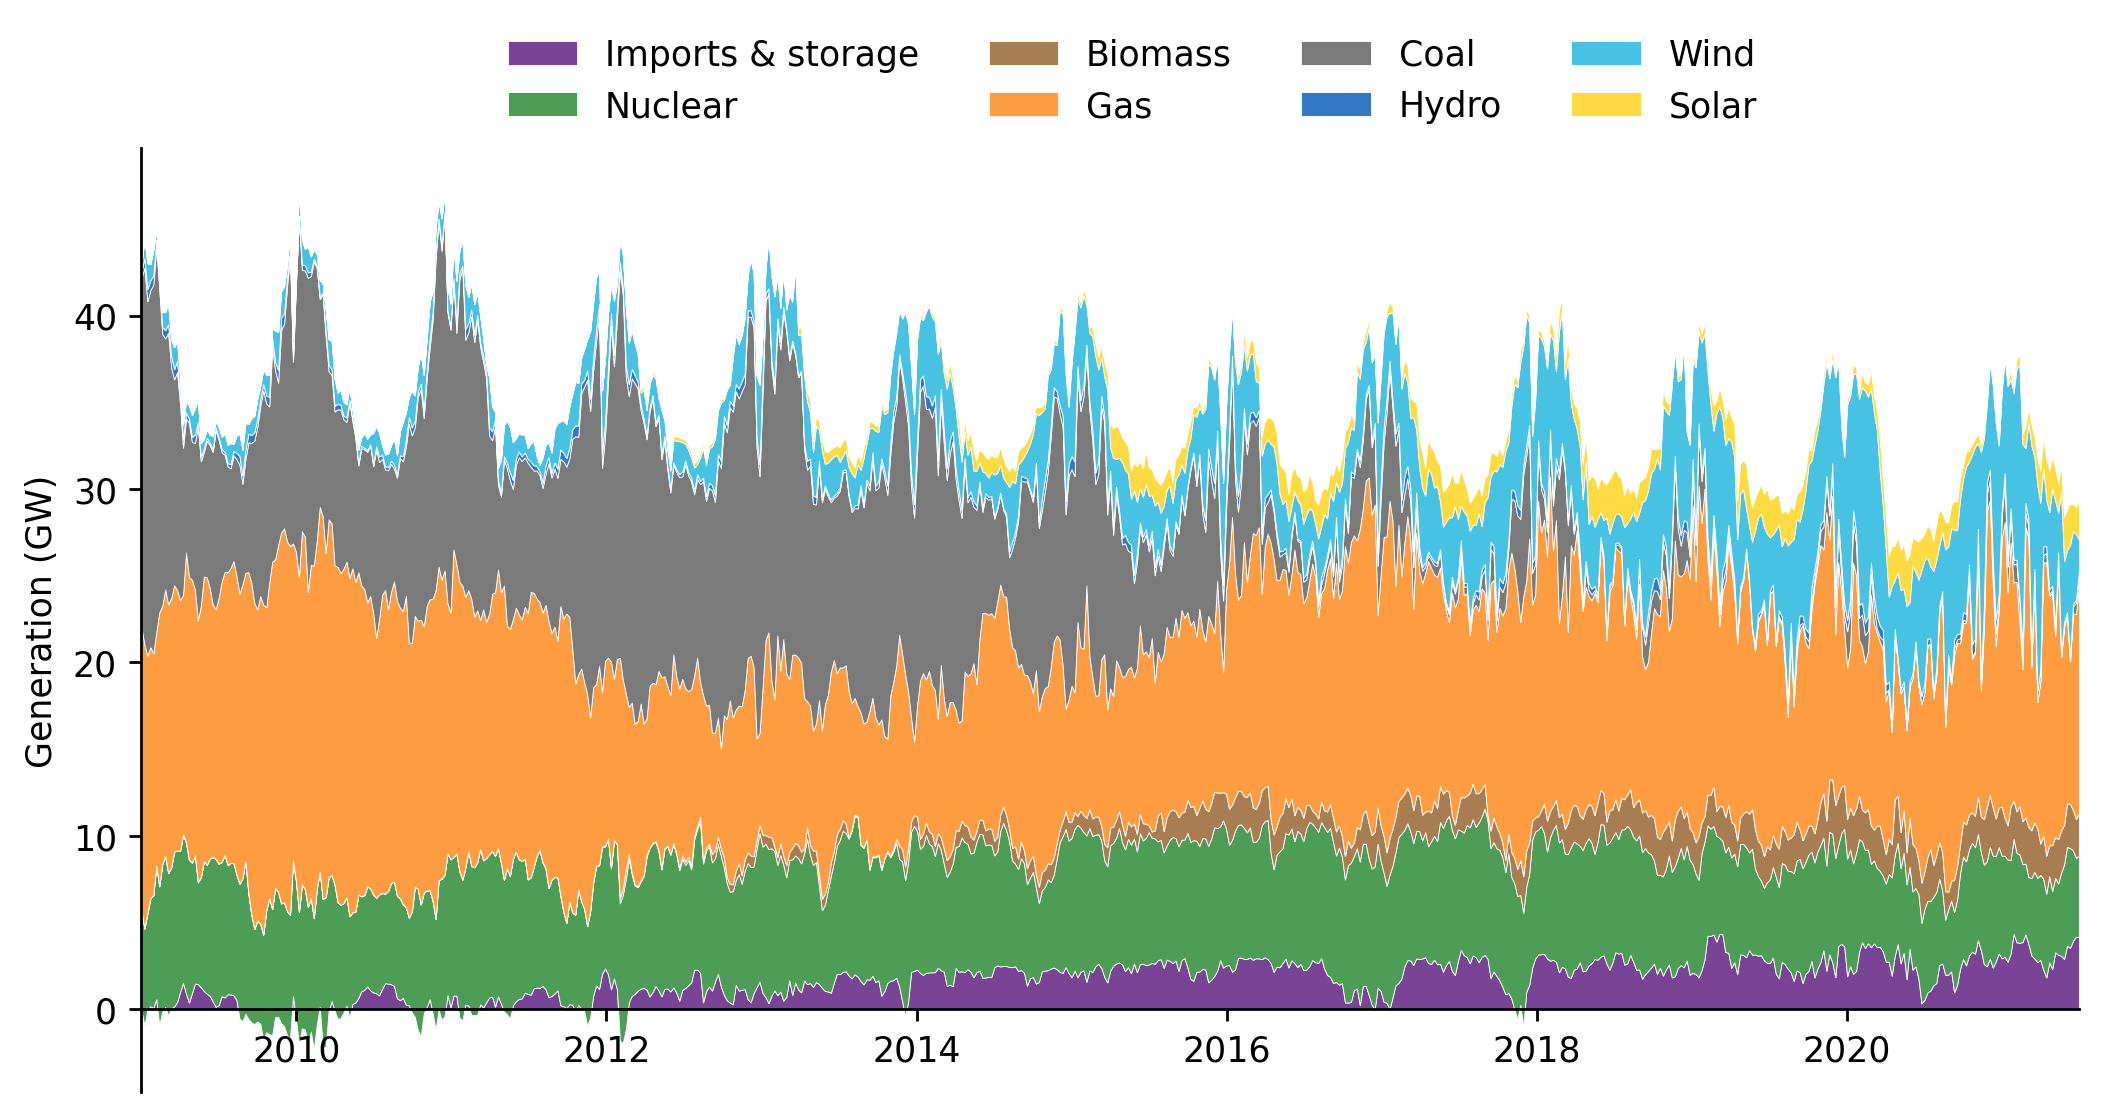

In [13]:
save_path = '../docs/img/vis/ei_stacked_fuel.png'

stacked_fuel_plot(df_ei_plot, dpi=250, save_path=save_path)

In [14]:
#exports
def construct_GB_decarb_progess_md_txt(
    img_fp: str='docs/img/vis/ei_stacked_fuel.png',
    update_time: str=pd.Timestamp.now().round('5min').strftime('%Y-%m-%d %H:%M')
):
    md_txt = f"""### Measuring the Progress and Impacts of Decarbonising British Electricity
    
The figures shown here are attempts to replicate the visualisations from [this paper](https://www.sciencedirect.com/science/article/pii/S0301421516307017) by Dr Iain Staffell which finds that:

* CO2 emissions from British electricity have fallen 46% in the three years to June 2016.
* Emissions from imports and biomass are not attributed to electricity, but add 5%.
* Coal capacity fell 50% and output 75% due to prices, competition and legislation.
* Wind, solar and biomass provided 20% of demand in 2015, with a peak of 45%.
* Prices have become more volatile and net demand is falling towards must-run nuclear.

These figures will be updated on a weekly basis, the last update was at: {update_time}
    
<br>

#### Weekly Averaged Generation Mix

The following figure shows a stacked plot of the generation from different fuel types over time, averaged on a weekly basis. The original plot can be found [here](https://www.sciencedirect.com/science/article/pii/S0301421516307017#f0030), the following description is taken directly from the paper.

> Over this period fossil fuels have become increasingly squeezed by the growth of imports, biomass, wind and solar. Coal is seen responding to seasonal changes in demand, and displaced gas over the second half of 2011. Gas generation fell steadily from an average of 17.3 GW in 2009–10 to just 9.3 GW in 2012–13. This trend reversed over the course of 2015 with gas generation rising from an average of 9.0 GW in the first quarter of 2015 to 13.8 GW in the first quarter of 2016. By May 2016 coal generation fell to an average of just 1.1 GW, and on the 10th of May instantaneous coal output fell to zero for the first in over 130 years.

![]({img_fp})
"""
    
    return md_txt

In [15]:
img_fp = '../docs/img/vis/ei_stacked_fuel.png'

md_txt = construct_GB_decarb_progess_md_txt(img_fp)

print(md_txt)

### Measuring the Progress and Impacts of Decarbonising British Electricity
    
The figures shown here are attempts to replicate the visualisations from [this paper](https://www.sciencedirect.com/science/article/pii/S0301421516307017) by Dr Iain Staffell which finds that:

* CO2 emissions from British electricity have fallen 46% in the three years to June 2016.
* Emissions from imports and biomass are not attributed to electricity, but add 5%.
* Coal capacity fell 50% and output 75% due to prices, competition and legislation.
* Wind, solar and biomass provided 20% of demand in 2015, with a peak of 45%.
* Prices have become more volatile and net demand is falling towards must-run nuclear.

These figures will be updated on a weekly basis, the last update was at: 2021-07-03 10:20
    
<br>

#### Weekly Averaged Generation Mix

The following figure shows a stacked plot of the generation from different fuel types over time, averaged on a weekly basis. The original plot can be found [here](

In [16]:
#exports
def generate_GB_decarb_progess(
    dt_col: str='local_datetime',
    dt_tz: str='Europe/London',
    url: str='https://api.github.com/repos/AyrtonB/Electric-Insights/git/trees/master?recursive=1',
    raw_file_prefix: str='https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/',
    docs_dir: str='docs',
    update_time: str=pd.Timestamp.now().round('5min').strftime('%Y-%m-%d %H:%M'),
    dpi=250,
    freq='7D',
    use_preloaded_ei_df=True,
    fuel_colour_dict = {
    'Imports & Storage' : rgb_2_plt_tuple(121,68,149), 
    'nuclear' : rgb_2_plt_tuple(77,157,87), 
    'biomass' : rgb_2_plt_tuple(168,125,81), 
    'gas' : rgb_2_plt_tuple(254,156,66), 
    'coal' : rgb_2_plt_tuple(122,122,122), 
    'hydro' : rgb_2_plt_tuple(50,120,196), 
    'wind' : rgb_2_plt_tuple(72,194,227), 
    'solar' : rgb_2_plt_tuple(255,219,65),
}
):
    df_ei = globals()['df_ei']
    if (use_preloaded_ei_df == True) and (df_ei is not None):
        pass
    else:
        df_ei = get_ei_df(dt_col=dt_col, dt_tz=dt_tz, url=url, raw_file_prefix=raw_file_prefix)
        
    df_ei_plot = clean_EI_df_for_plot(df_ei, freq=freq)
    
    img_name = 'ei_stacked_fuel'
    stacked_fuel_plot(df_ei_plot, dpi=250, save_path=f'{docs_dir}/img/vis/{img_name}.png')
    md_txt = construct_GB_decarb_progess_md_txt(img_fp=f'img/vis/{img_name}.png', update_time=update_time)
    
    return md_txt

In [17]:
md_txt = generate_GB_decarb_progess(docs_dir='../docs')
plt.close()

<br>

### Merit Order Effect Modelling

#### Price Surface Estimation

In [24]:
#exports
def get_price_dispatchable_s(df_ei):
    df_ei_model = df_ei[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

    s_price = df_ei_model['day_ahead_price']
    s_dispatchable = df_ei_model['demand'] - df_ei_model[['solar', 'wind']].sum(axis=1)
    
    return s_price, s_dispatchable

In [25]:
s_price, s_dispatchable = get_price_dispatchable_s(df_ei)

s_dispatchable.head()

local_datetime
2009-01-01 00:00:00+00:00    38.181
2009-01-01 00:30:00+00:00    38.304
2009-01-01 01:00:00+00:00    37.839
2009-01-01 01:30:00+00:00    36.716
2009-01-01 02:00:00+00:00    36.020
dtype: float64

In [54]:
#exports
def construct_reg_dates(
    reg_dates_start: str='2010-01-01',
    reg_dates_end: str=None,
    reg_dates_freq: str='13W'
):
    if reg_dates_end is None:
        reg_dates_end = pd.Timestamp.now().strftime('%Y-%m-%d')
        
    reg_dates = pd.date_range(reg_dates_start,  reg_dates_end, freq=reg_dates_freq)
    
    return reg_dates

In [55]:
reg_dates = construct_reg_dates(reg_dates_start=reg_dates_start)

reg_dates[:5]

DatetimeIndex(['2010-01-03', '2010-04-04', '2010-07-04', '2010-10-03',
               '2011-01-02'],
              dtype='datetime64[ns]', freq='13W-SUN')

In [56]:
#exports
def estimate_ts_surface(
    x: pd.Series, 
    y: pd.Series, 
    reg_dates: pd.core.indexes.datetimes.DatetimeIndex, 
    num_fits: int=15, 
    x_pred: np.ndarray=None,
    dt_idx: pd.core.indexes.datetimes.DatetimeIndex=None,
    reg_dates_start: str='2010-01-01',
    reg_dates_end: str=None,
):
    if dt_idx is None:
        dt_idx = x.index
        
    if x_pred is None:
        x_pred = np.linspace(10, 60, 521)
        
    if reg_dates_end is None:
        reg_dates_end = pd.Timestamp.now().strftime('%Y-%m-%d')
        
    smooth_dates = lowess.SmoothDates()

    smooth_dates.fit(
        dt_idx=dt_idx, 
        x=x.values, 
        y=y.values, 
        reg_dates=reg_dates, 
        num_fits=num_fits
    )
    
    dt_pred = pd.date_range(reg_dates_start, reg_dates_end)
    df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)

    return df_pred

In [35]:
df_pred = estimate_ts_surface(s_dispatchable, s_price, reg_dates)

df_pred.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [04:27<00:00,  5.69s/it]


,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-09,2010-01-10,...,2021-06-24,2021-06-25,2021-06-26,2021-06-27,2021-06-28,2021-06-29,2021-06-30,2021-07-01,2021-07-02,2021-07-03
10.000000,19.348313,19.364551,19.380763,19.396946,19.413105,19.429243,19.445363,19.461468,19.477562,19.493646,...,14.425101,14.432795,14.440559,14.448392,14.456295,14.464268,14.472309,14.480419,14.488598,14.496844
10.096154,19.390991,19.407254,19.423491,19.439700,19.455885,19.472049,19.488196,19.504328,19.520449,19.536560,...,14.740208,14.747955,14.755771,14.763657,14.771613,14.779639,14.787733,14.795896,14.804127,14.812426
10.192308,19.433949,19.450237,19.466499,19.482734,19.498945,19.515134,19.531307,19.547466,19.563613,19.579752,...,15.054663,15.062461,15.070330,15.078269,15.086277,15.094355,15.102501,15.110717,15.119000,15.127352
10.288462,19.477209,19.493522,19.509809,19.526068,19.542304,19.558519,19.574718,19.590902,19.607076,19.623242,...,15.368434,15.376285,15.384206,15.392196,15.400257,15.408387,15.416585,15.424853,15.433189,15.441592
10.384615,19.520790,19.537126,19.553437,19.569722,19.585982,19.602222,19.618446,19.634656,19.650856,19.667048,...,15.681498,15.689400,15.697373,15.705415,15.713528,15.721709,15.729960,15.738279,15.746667,15.755123


In [36]:
#exports
def plot_ts_surface_estimate(
    df_pred, 
    s_dispatchable, 
    dpi=250, 
    save_path=None,
    reg_dates_start: str='2010-01-01',
    reg_dates_end: str=None,
):
    if reg_dates_end is None:
        reg_dates_end = pd.Timestamp.now().strftime('%Y-%m-%d')
        
    # Preparing mask
    df_dispatchable_lims = moe.construct_dispatchable_lims_df(s_dispatchable['2010':])
    df_pred_mask = moe.construct_pred_mask_df(df_pred, df_dispatchable_lims)

    # Plotting
    fig, ax = plt.subplots(dpi=dpi, figsize=(8, 5))

    htmp = sns.heatmap(df_pred[10:60].where(df_pred_mask[10:60], np.nan).iloc[::-1], ax=ax, cbar_kws={'label': 'Price (£/MWh)'})

    moe.set_ticks(ax, np.arange(0, 70, 10), axis='y')
    moe.set_date_ticks(ax, reg_dates_start, reg_dates_end, freq='1YS', date_format='%Y', axis='x')

    for _, spine in htmp.spines.items():
        spine.set_visible(True)
    eda.hide_spines(ax)

    ax.set_ylabel('Demand - [Solar + Wind] (GW)')

    # Saving
    if save_path is not None:
        fig.savefig(save_path)

C:\Users\Ayrto\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


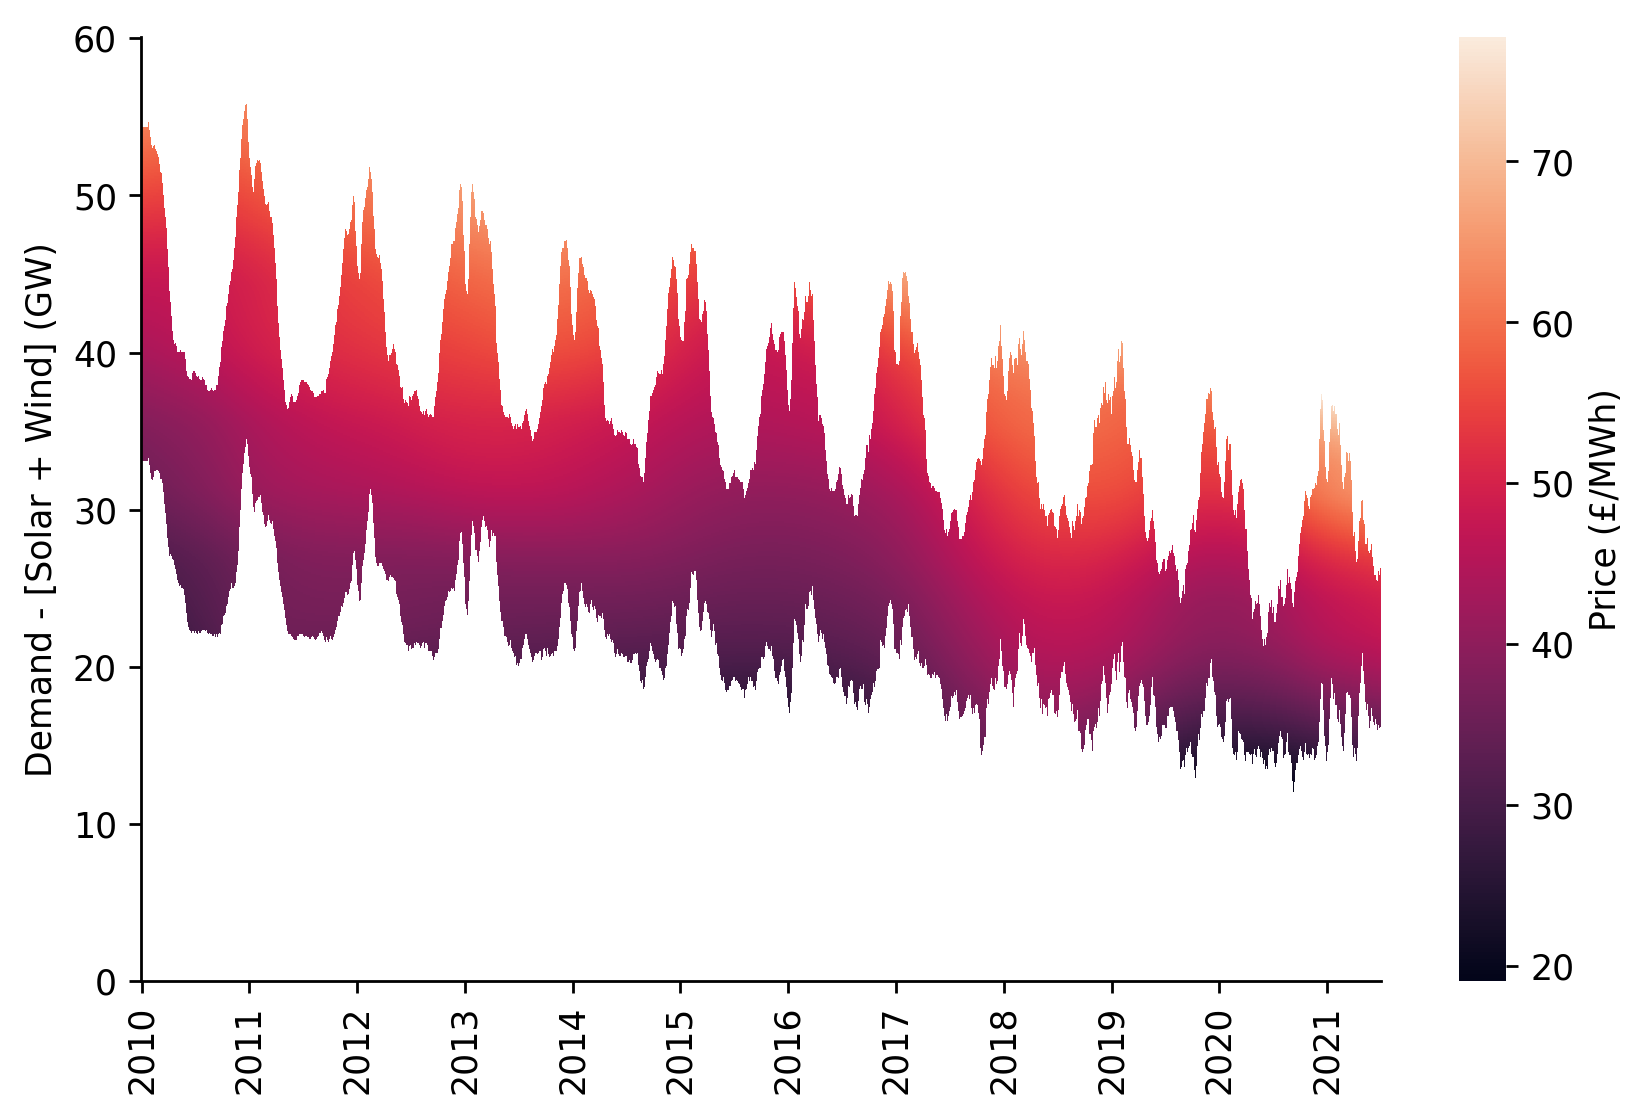

In [39]:
save_path = '../docs/img/vis/moe_surface.png'

plot_ts_surface_estimate(df_pred, s_dispatchable, save_path=save_path)

In [43]:
#exports
def construct_moe_md_txt(
    img_fp: str='docs/img/vis/moe_surface.png',
    update_time: str=None
):
    if update_time is None:
        update_time = pd.Timestamp.now().round('5min').strftime('%Y-%m-%d %H:%M')
        
    md_txt = f"""### Marginal Price Curve Estimation
    
The figure shown here is reproduced from the work in [this paper](https://ayrtonb.github.io/Merit-Order-Effect/#paper) by Ayrton Bourn which investigates the merit order effect of renewables in the GB and DE power markets in terms of the price and carbon reductions - the key findings are as follows:

* A LOWESS estimation of the non-linear marginal price curve for dispatchable generation shows high back-casting accuracy for Germany and Britain
* The evolving Merit Order Effect (MOE) was estimated through a time-adaptive model, enabling long-term trends to be captured
* In Britain the MOE has increased sharply since 2016, with a 0.67% price reduction per p.p. increase in RES penetration
* Disaggregation of the MOE by fuel-type highlights key differences in the transition paths of Britain and Germany

This figure will be updated on a weekly basis, the last update was at: {update_time}
    
<br>

#### Smoothed Price Time-Series Surface

This figure shows the LOWESS (Locally Weighted Scatterplot Smoothing) regressions for the day-ahead marginal price curve visualised as a heatmap surface, highlighting the seasonal and non-cyclical changes over time. A mask has been applied where the residual demand after RES is outside the range of 99% of the data. This view is particularly helpful for picking up long-term trends in the market, for example the higher power prices seen in 18/19 due to high gas prices.


![]({img_fp})
"""
    
    return md_txt

In [42]:
img_fp = '../docs/img/vis/moe_surface.png'

md_txt = construct_moe_md_txt(img_fp)

print(md_txt)

### Marginal Price Curve Estimation
    
The figure shown here is reproduced from the work in [this paper](https://ayrtonb.github.io/Merit-Order-Effect/#paper) by Ayrton Bourn which investigates the merit order effect of renewables in the GB and DE power markets in terms of the price and carbon reductions. The key findings are as follows:

* A LOWESS estimation of the non-linear marginal price curve for dispatchable generation shows high back-casting accuracy for Germany and Britain
* The evolving Merit Order Effect (MOE) was estimated through a time-adaptive model, enabling long-term trends to be captured
* In Britain the MOE has increased sharply since 2016, with a 0.67% price reduction per p.p. increase in RES penetration
* Disaggregation of the MOE by fuel-type highlights key differences in the transition paths of Britain and Germany

This figure will be updated on a weekly basis, the last update was at: 2021-07-03 12:40
    
<br>

#### Smoothed Price Time-Series Surface

This figu

In [62]:
#exports
def generate_moe(
    dt_col: str='local_datetime',
    dt_tz: str='Europe/London',
    url: str='https://api.github.com/repos/AyrtonB/Electric-Insights/git/trees/master?recursive=1',
    raw_file_prefix: str='https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/',
    reg_dates_start: str='2010-01-01',
    reg_dates_end: str=pd.Timestamp.now().strftime('%Y-%m-%d'),
    reg_dates_freq: str='13W',
    num_fits: int=15, 
    x_pred: np.ndarray=np.linspace(10, 60, 521),
    dt_idx: pd.core.indexes.datetimes.DatetimeIndex=None,
    dpi: int=250, 
    use_preloaded_ei_df: bool=True,
    img_name: str='moe_surface',
    docs_dir: str='docs'
):
    df_ei = globals()['df_ei']
    if (use_preloaded_ei_df == True) and (df_ei is not None):
        pass
    else:
        df_ei = get_ei_df(dt_col=dt_col, dt_tz=dt_tz, url=url, raw_file_prefix=raw_file_prefix)
        
    s_price, s_dispatchable = get_price_dispatchable_s(df_ei)
    reg_dates = construct_reg_dates(reg_dates_start=reg_dates_start, reg_dates_end=reg_dates_end, reg_dates_freq=reg_dates_freq)
    
    df_pred = estimate_ts_surface(s_dispatchable, s_price, reg_dates,num_fits=num_fits, x_pred=x_pred, dt_idx=dt_idx, reg_dates_start=reg_dates_start, reg_dates_end=reg_dates_end)
    
    plot_ts_surface_estimate(df_pred, s_dispatchable, dpi=dpi, save_path=f'{docs_dir}/img/vis/{img_name}.png', reg_dates_start=reg_dates_start, reg_dates_end=reg_dates_end)
    md_txt = construct_moe_md_txt(img_fp=f'img/vis/{img_name}.png')
    
    return md_txt

In [63]:
docs_dir = '../docs'

md_txt = generate_moe(docs_dir=docs_dir)
plt.close()

In [66]:
#hide
from ElexonDataPortal.dev.nbdev import notebook2script
notebook2script('vis-01-ei.ipynb')

Converted vis-01-ei.ipynb.
